# CytoNormPy - AnnData objects

In this vignette, we showcase a typical analysis workflow using anndata objects.

First, we import the necessary libraries and create the anndata object.

In [1]:
import cytonormpy as cnp

import anndata as ad
import pandas as pd
import os
import numpy as np


from cytonormpy import FCSFile

## AnnData creation

We use the internal representation to create an AnnData object as follows:

In [2]:
def _fcs_to_anndata(input_directory, file, file_no, metadata) -> ad.AnnData:
    fcs = FCSFile(input_directory=input_directory, file_name=file)
    events = fcs.original_events
    md_row = metadata.loc[metadata["file_name"] == file, :].to_numpy()
    obs = np.repeat(md_row, events.shape[0], axis=0)
    var_frame = fcs.channels
    obs_frame = pd.DataFrame(
        data=obs,
        columns=metadata.columns,
        index=pd.Index([f"{file_no}-{str(i)}" for i in range(events.shape[0])]),
    )
    adata = ad.AnnData(obs=obs_frame, var=var_frame, layers={"compensated": events})
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    return adata

In [3]:
input_directory = "../_resources/"
fcs_files = [
    "Gates_PTLG021_Unstim_Control_1.fcs",
    "Gates_PTLG021_Unstim_Control_2.fcs",
    "Gates_PTLG028_Unstim_Control_1.fcs",
    "Gates_PTLG028_Unstim_Control_2.fcs",
    "Gates_PTLG034_Unstim_Control_1.fcs",
    "Gates_PTLG034_Unstim_Control_2.fcs",
]
adatas = []
metadata = pd.read_csv(os.path.join(input_directory, "metadata_sid.csv"))
for file_no, file in enumerate(fcs_files):
    adatas.append(_fcs_to_anndata(input_directory, file, file_no, metadata))

dataset = ad.concat(adatas, axis=0, join="outer", merge="same")
dataset.obs = dataset.obs.astype("object")
dataset.var = dataset.var.astype("object")
dataset.obs_names_make_unique()
dataset.var_names_make_unique()

In [4]:
dataset

AnnData object with n_obs × n_vars = 6000 × 55
    obs: 'file_name', 'reference', 'batch', 'sample_ID'
    var: 'pns', 'png', 'pne', 'channel_numbers'
    layers: 'compensated'

## Data setup

We instantiate the cytonorm object and add a data transformer that will transform our data to the asinh space and the clusterer that will cluster the cells.

In [5]:
cn = cnp.CytoNorm()

t = cnp.AsinhTransformer()
fs = cnp.FlowSOM(n_clusters=10)

cn.add_transformer(t)
cn.add_clusterer(fs)

Next, we run the `run_anndata_setup()` method.

In [6]:
cn.run_anndata_setup(dataset, layer="compensated", key_added="normalized", n_cells_reference=1000)

## CV thresholding

For clustering, it is important to visualize the distribution of files within one cluster. We have already added a FlowSOM Clusterer instance. the function 'calculate_cluster_cvs' will now calculate, for each metacluster number that we want to analyze, the cluster cv per sample.

We then visualize it via a waterfall plot as in the original CytoNorm implementation in R.

_CytoNorm2.0_: We can now use a different set of markers for clustering using the 'markers' parameter. If you want to use all markers, do not pass anything!

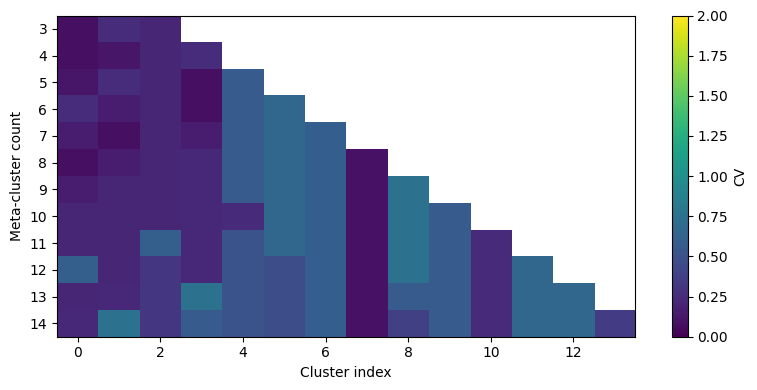

In [7]:
markers_for_clustering = dataset.var_names[4:15].tolist()

cn.calculate_cluster_cvs(n_metaclusters=list(range(3, 15)), markers=markers_for_clustering)
cnp.pl.cv_heatmap(cn, n_metaclusters=list(range(3, 15)), max_cv=2)

## Clustering

We run the FlowSOM clustering and pass a `cluster_cv_threshold` of 2. This value is used to evaluate if the distribution of files within one cluster is sufficient. A warning will be raised if that is not the case. We can see from above that, regardless of which metacluster number we choose, this will not be the case!

In [8]:
cn.run_clustering(markers=markers_for_clustering, cluster_cv_threshold=2)

## Calculation

Finally, we calculate the quantiles per batch and cluster, calculate the spline functions and transform the expression values accordingly.

The data will automatically be saved to the anndata object in the layer "normalized". In order to change the layer name, use the keyword `key_added` in the `run_anndata_setup()` method from above.

In [9]:
cn.calculate_quantiles()
cn.calculate_splines(goal="batch_mean")
cn.normalize_data()

C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 24 cells detected in batch 1 for cluster 3. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 7 cells detected in batch 1 for cluster 4. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 17 cells detected in batch 1 for cluster 7. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 6 cells detected in batch 1 for cluster 8. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524

normalized file Gates_PTLG021_Unstim_Control_1.fcs
normalized file Gates_PTLG021_Unstim_Control_2.fcs
normalized file Gates_PTLG034_Unstim_Control_1.fcs
normalized file Gates_PTLG028_Unstim_Control_1.fcs
normalized file Gates_PTLG028_Unstim_Control_2.fcs
normalized file Gates_PTLG034_Unstim_Control_2.fcs


In [10]:
dataset

AnnData object with n_obs × n_vars = 6000 × 55
    obs: 'file_name', 'reference', 'batch', 'sample_ID'
    var: 'pns', 'png', 'pne', 'channel_numbers'
    layers: 'compensated', 'normalized'

In order to run the algorithm on new data, we can just pass the updated anndata and specify the necessary file names.

We will first create the new anndata object that contains an additional file.

In [11]:
filename = "Gates_PTLG034_Unstim_Control_2_dup.fcs"
metadata = pd.DataFrame(data=[[filename, "other", 3]], columns=["file_name", "reference", "batch"])
new_adata = _fcs_to_anndata(input_directory, filename, 7, metadata)

dataset = ad.concat([dataset, new_adata], axis=0, join="outer")
dataset

AnnData object with n_obs × n_vars = 7000 × 55
    obs: 'file_name', 'reference', 'batch', 'sample_ID'
    layers: 'compensated', 'normalized'

Currently, all 'normalized' values for the new file are NaN:

In [12]:
dataset[dataset.obs["file_name"] == filename, :].to_df(layer="normalized").head()

,Time,Event_length,Y89Di,Pd102Di,Pd104Di,Pd105Di,Pd106Di,Pd108Di,Pd110Di,In113Di,...,Yb171Di,Yb172Di,Yb173Di,Yb174Di,Lu175Di,Yb176Di,Ir191Di,Ir193Di,Pt195Di,beadDist
7-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
cn.normalize_data(adata=dataset, file_names=filename, batches=3)

normalized file Gates_PTLG034_Unstim_Control_2_dup.fcs


The normalized values are now stored inplace!

In [14]:
dataset[dataset.obs["file_name"] == filename, :].to_df(layer="normalized").head()

,Time,Event_length,Y89Di,Pd102Di,Pd104Di,Pd105Di,Pd106Di,Pd108Di,Pd110Di,In113Di,...,Yb171Di,Yb172Di,Yb173Di,Yb174Di,Lu175Di,Yb176Di,Ir191Di,Ir193Di,Pt195Di,beadDist
7-0,134.582993,16.0,0.000000,8.679433,8.292034,75.802243,9.135942,102.328946,75.562056,0.000488,...,0.245267,2.841038,0.077476,9.155870,8.721652,20.603478,42.043896,118.089443,0.000885,27.542093
7-1,307.864990,25.0,0.002169,10.821452,6.606235,142.933832,124.046685,231.742272,313.555878,0.000000,...,7.293311,3.704368,13.276683,164.605647,6.250109,6.026575,58.298905,108.974573,0.000000,31.969299
7-2,370.299011,13.0,0.003742,32.530681,12.905950,196.132910,46.107563,261.139574,249.113909,0.000000,...,5.781553,65.096013,2.148641,0.015413,0.010149,1.321422,121.642487,260.703220,0.000000,34.630819
7-3,390.078003,25.0,0.000000,3.518037,5.657144,151.235453,18.623958,176.520250,121.060864,0.000488,...,3.005988,3.015534,91.248730,30.708479,0.074746,13.267579,81.579132,152.255885,0.000885,32.892003
7-4,723.723999,15.0,0.000000,4.033677,0.000000,23.492430,0.000000,48.940914,30.778446,3.794250,...,0.000000,0.000000,0.000000,0.180230,0.000000,3.118176,4.195136,9.201713,0.000000,31.036688


In [15]:
dataset

AnnData object with n_obs × n_vars = 7000 × 55
    obs: 'file_name', 'reference', 'batch', 'sample_ID'
    layers: 'compensated', 'normalized'